In [64]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [65]:
EPOCHS = 20
data_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

<h3>Preprocessing the data</h3>

In [66]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),  
            transforms.CenterCrop(224),  
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  
        ])
        
    if phase == VAL:

        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])        
        
    return transform  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) 

cuda:0


<h3>Load the data</h3>

In [67]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x)) 
                  for x in [TRAIN, VAL, TEST]}


dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 4, shuffle=True), 
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True), 
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)
}

In [68]:
print(len(dataloaders[TRAIN]))
print(len(dataloaders[TEST]))
print(len(dataloaders[VAL]))

1304
624
16


In [69]:
dataset_sizes = {
    x: len(image_datasets[x]) 
    for x in [TRAIN, VAL]
}


classes = image_datasets[TRAIN].classes

class_names = image_datasets[TRAIN].classes

<h3>Visualize the data</h3>

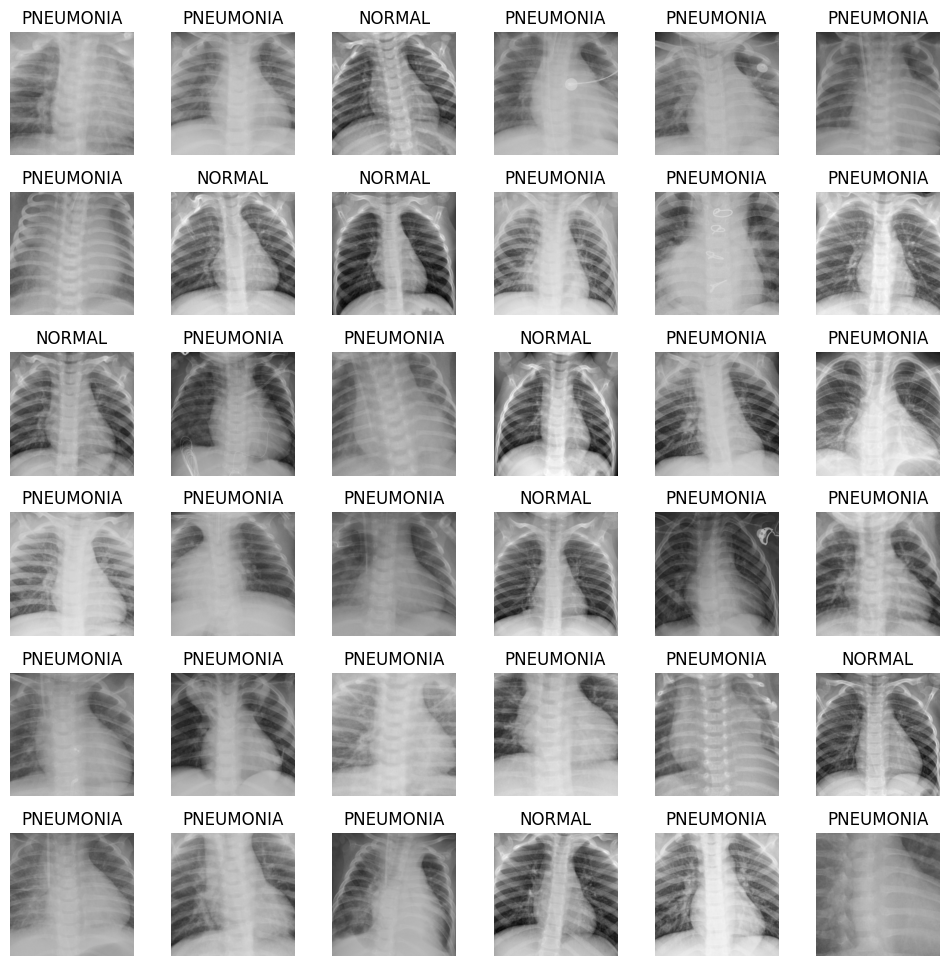

In [70]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(6):
    for j in range(6):
        inputs, classes = next(iter(dataloaders[TRAIN]))
        input_img = inputs[0]
        class_label = classes[0]
        inp = input_img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j].imshow(inp)
        axes[i, j].set_title(class_names[class_label.item()])
        axes[i, j].axis('off')

plt.show()

In [71]:
inputs, classes = next(iter(dataloaders[TRAIN]))

<h3>Define model</h3>

In [72]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs):
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
    
#     history = {
#         'train_loss': [],
#         'val_loss': [],
#         'train_acc': [],
#         'val_acc': []
#     }
    
#     for epoch in range(num_epochs):
#         print("Epoch: {}/{}".format(epoch+1, num_epochs))
#         print("="*10)
        
#         for phase in [TRAIN, VAL]:
#             if phase == TRAIN:
#                 scheduler.step()
#                 model.train()  
#             else:
#                 model.eval()  

#             running_loss = 0.0
#             running_corrects = 0

#             for data in dataloaders[phase]:
#                 inputs, labels = data
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 optimizer.zero_grad()

#                 # Forward pass
#                 with torch.set_grad_enabled(phase==TRAIN):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # Backward pass and optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # Statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             # Deep copy the model if we have a new best validation accuracy
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#     print('Best val Acc: {:4f}'.format(best_acc))

#     # Load best model weights and return the model
#     model.load_state_dict(best_model_wts)
#     return model

import copy
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model if we have a new best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights and return the model
    model.load_state_dict(best_model_wts)
    return model, history


def plot_history(history):
    epochs = range(len(history['train_loss']))
    
    # Loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'r-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'b-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'r-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'b-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()






In [73]:
def rename_keys(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("norm.1", "norm1").replace("norm.2", "norm2").replace("conv.1", "conv1").replace("conv.2", "conv2")
        new_state_dict[new_key] = value
    return new_state_dict


In [74]:
import torch
import torch.nn as nn
from torchvision import models

# Đường dẫn tới tệp mô hình đã tải lên
model_path = '/kaggle/input/chexnet/pytorch/chest_xray_chexnet/1/densenet121-a639ec97.pth'

# Load state_dict từ tệp cục bộ
state_dict = torch.load(model_path)

# Chuyển đổi khóa trong state_dict
state_dict = rename_keys(state_dict)

# Load pre-trained DenseNet-121 từ tệp cục bộ
model_pre = models.densenet121()
model_pre.load_state_dict(state_dict)

# # Modify the classifier to match the number of classes in your dataset
# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, len(class_names))

# # Move the model to GPU if available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)


<All keys matched successfully>

In [75]:
for param in model_pre.features.parameters():
    param.required_grad = False

# Sửa đổi lớp classifier để phù hợp với số lượng lớp trong dataset
num_features = model_pre.classifier.in_features
model_pre.classifier = nn.Linear(num_features, len(class_names))

# Di chuyển mô hình tới GPU nếu có
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_pre = model_pre.to(device)

print(model_pre)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [76]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [78]:
# model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)
# Ensure tensors are on CPU before converting to numpy

# Sử dụng hàm train_model và plot_history
model_pre, history = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)
history['train_loss'] = [x.cpu().numpy() for x in history['train_loss']]
history['val_loss'] = [x.cpu().numpy() for x in history['val_loss']]
history['train_acc'] = [x.cpu().numpy() for x in history['train_acc']]
history['val_acc'] = [x.cpu().numpy() for x in history['val_acc']]
plot_history(history)

Epoch: 1/20
train Loss: 0.2250 Acc: 0.9224
val Loss: 0.4716 Acc: 0.6875
Epoch: 2/20
train Loss: 0.1216 Acc: 0.9630
val Loss: 0.3917 Acc: 0.8125
Epoch: 3/20
train Loss: 0.0970 Acc: 0.9755
val Loss: 0.1902 Acc: 0.9375
Epoch: 4/20
train Loss: 0.0934 Acc: 0.9739
val Loss: 0.8559 Acc: 0.5625
Epoch: 5/20
train Loss: 0.0810 Acc: 0.9768
val Loss: 1.2046 Acc: 0.5000
Epoch: 6/20
train Loss: 0.0617 Acc: 0.9824
val Loss: 0.5072 Acc: 0.7500
Epoch: 7/20
train Loss: 0.0477 Acc: 0.9868
val Loss: 0.2304 Acc: 0.8125
Epoch: 8/20
train Loss: 0.0541 Acc: 0.9831
val Loss: 0.3863 Acc: 0.8750
Epoch: 9/20
train Loss: 0.0664 Acc: 0.9780
val Loss: 0.5694 Acc: 0.6875
Epoch: 10/20
train Loss: 0.0195 Acc: 0.9965
val Loss: 0.2840 Acc: 0.8125
Epoch: 11/20
train Loss: 0.0149 Acc: 0.9975
val Loss: 0.3060 Acc: 0.8750
Epoch: 12/20
train Loss: 0.0153 Acc: 0.9977
val Loss: 0.2917 Acc: 0.8750
Epoch: 13/20
train Loss: 0.0154 Acc: 0.9952
val Loss: 0.2460 Acc: 0.8125
Epoch: 15/20
train Loss: 0.0099 Acc: 0.9973
val Loss: 0.5630

AttributeError: 'float' object has no attribute 'cpu'

In [ ]:
# import copy
# import torch.optim as optim
# from torchvision import models

# def save_model(model, optimizer, epoch, loss, filename):
#     """
#     Lưu mô hình PyTorch, trạng thái optimizer, số epoch và loss hiện tại vào thư mục output của Kaggle.

#     Args:
#     - model (torch.nn.Module): Mô hình cần lưu.
#     - optimizer (torch.optim.Optimizer): Optimizer của mô hình.
#     - epoch (int): Số epoch hiện tại.
#     - loss (float): Giá trị loss hiện tại.
#     - filename (str): Tên file để lưu checkpoint.

#     Returns:
#     - None
#     """
#     path = f'/kaggle/working/{filename}'
#     checkpoint = {
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'epoch': epoch,
#         'loss': loss
#     }
#     torch.save(checkpoint, path)
#     print(f'Model saved to {path}')

# def load_model(model, optimizer, filename):
#     """
#     Tải mô hình PyTorch và trạng thái optimizer từ file checkpoint trong thư mục output của Kaggle.

#     Args:
#     - model (torch.nn.Module): Mô hình cần tải.
#     - optimizer (torch.optim.Optimizer): Optimizer của mô hình.
#     - filename (str): Tên file checkpoint.

#     Returns:
#     - model (torch.nn.Module): Mô hình đã được tải trạng thái.
#     - optimizer (torch.optim.Optimizer): Optimizer đã được tải trạng thái.
#     - epoch (int): Số epoch hiện tại.
#     - loss (float): Giá trị loss hiện tại.
#     """
#     path = f'/kaggle/working/{filename}'
#     checkpoint = torch.load(path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     epoch = checkpoint['epoch']
#     loss = checkpoint['loss']
#     print(f'Model loaded from {path}, epoch: {epoch}, loss: {loss}')
#     return model, optimizer, epoch, loss

# # Example: Assuming you have these variables from your script

# # Train model and save best model
# # model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)
# save_model(model_pre, optimizer, EPOCHS, 0.0, 'best_model.pth')

# # Load the model
# model_loaded, optimizer_loaded, start_epoch, loss = load_model(model_pre, optimizer, 'best_model.pth')


Accuracy: 0.8317
Precision: 0.8613
Recall: 0.8317
F1 Score: 0.8186


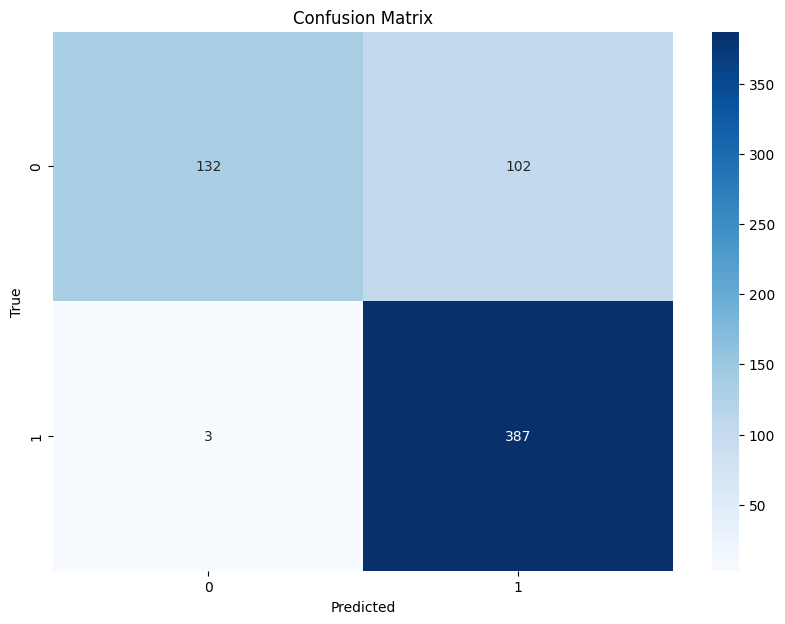

In [79]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def test_model():
    # Initialize counters
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    # No need to track gradients for testing
    with torch.no_grad():
        # Iterate over test data
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Store true labels
            true_labels.extend(labels.cpu().numpy())
            
            # Store model input images
            input_images.append(inputs.cpu().numpy())
            
            # Forward pass
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)

            # Store predicted labels
            pred_labels.extend(preds.cpu().numpy())

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total
        precision = precision_score(true_labels, pred_labels, average='weighted')
        recall = recall_score(true_labels, pred_labels, average='weighted')
        f1 = f1_score(true_labels, pred_labels, average='weighted')
        conf_matrix = confusion_matrix(true_labels, pred_labels)

    return true_labels, pred_labels, input_images, running_correct, running_total, acc, precision, recall, f1, conf_matrix

# Sử dụng hàm test_model
true_labels, pred_labels, input_images, running_correct, running_total, acc, precision, recall, f1, conf_matrix = test_model()

# In kết quả
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Vẽ confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
#true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(3):
    for j in range(3):
        # Get the image and labels
        inp = input_images[x].squeeze()
      
        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        
        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()


In [ ]:
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)